### Разберёмся в данных

In [1152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 3]

#### О пользователях

In [1153]:
users = pd.read_csv('data/users.csv')
print(f'dataset shape: {users.shape}')
users.head(7)

dataset shape: (27769, 4)


,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4
5,5,2,22,5
6,6,1,21,6


<AxesSubplot:>

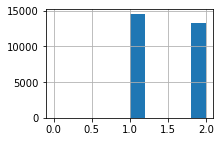

In [1154]:
# Пол пользователей

users.sex.hist(figsize=(3, 2))

<AxesSubplot:>

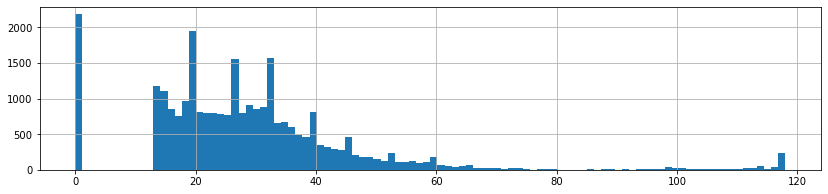

In [1155]:
# Возраст

users.age.hist(bins=100)

сделаем анализ распределения возрастов целевой аудитории

в кратце опишем данные

In [1156]:
users.age.describe()

count    27769.000000
mean        28.894847
std         18.510084
min          0.000000
25%         18.000000
50%         27.000000
75%         36.000000
max        118.000000
Name: age, dtype: float64

Посчитаем медианный возраст

In [1157]:
users.age.median()

27.0

посчитаем стандартное отклонение возраста

In [1158]:
users.age.std()

18.510083675073172

исходя из этого логично выбирать возраст аудитории в интервале от 0 до 65 лет, т.е. (0,65]
тем самым мы отбросим явные выбросы в указанных возрастах
Берём до 65, тк 95% попадают в этот диапазон

In [1159]:
users.age.median() - 2 * users.age.std()

-10.020167350146345

In [1160]:
users.age.median() + 2 * users.age.std()

64.02016735014635

<AxesSubplot:>

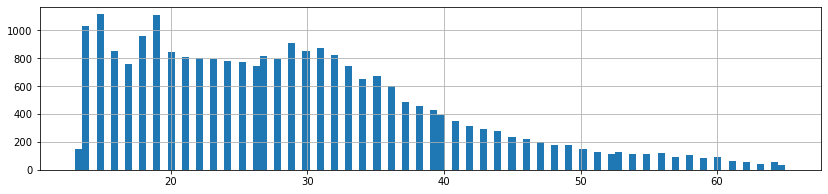

In [1161]:
# Возраст основной аудитории

users[(users.age > 0) & (users.age <= 65)].age.hist(bins=100)

Количество городов: 2457


<AxesSubplot:>

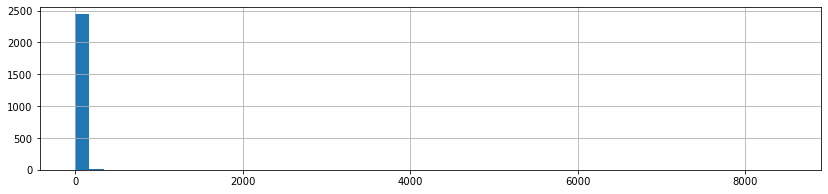

In [1162]:
# Города пользователей

print(f'Количество городов: {len(users.city_id.unique())}')
# Сколько пользователей в каждом городе
vc = users.value_counts('city_id')
vc.hist(bins=50)

<AxesSubplot:>

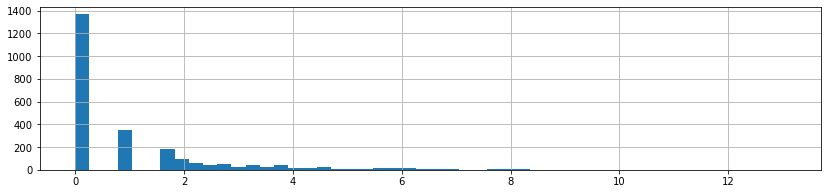

In [1163]:
# Логарифмированное количество жителей городов
log2_vc = np.log2(vc)
log2_vc.hist(bins=50)

##### Менее тривиальные графики

<AxesSubplot:>

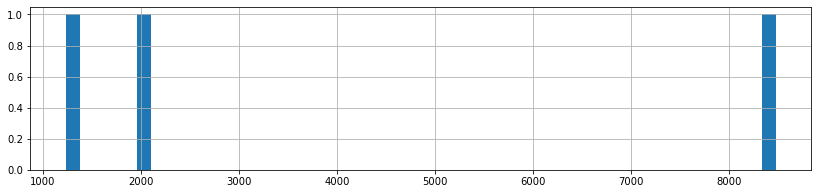

In [1164]:
# Города с населением более 1к
vc[vc > 1000].hist(bins=50)

In [1165]:
# Исследуем жителей больших городов
vc[vc > 1000]

city_id
0    8479
3    1985
7    1232
dtype: int64

In [1166]:
cities_users = users[users.city_id.isin([0, 3, 7])]
cities_users.shape

(11696, 4)

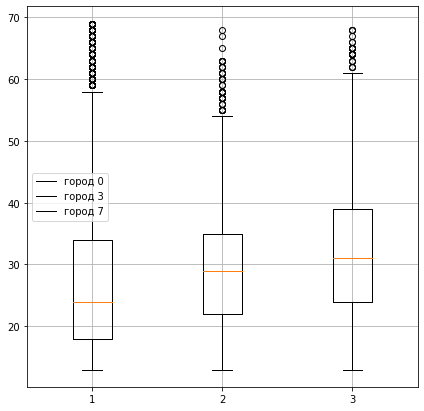

In [1167]:
# Их возраст по городам

city_ages = cities_users[(cities_users.age > 0) & (cities_users.age < 70)].groupby('city_id').age.apply(list)

plt.figure(figsize=(7, 7))
plt.boxplot(city_ages)
plt.grid(True)
plt.legend([f'город {city_id}' for city_id in city_ages.index])
plt.show()

#### О рекламных компаниях

In [1168]:
history = pd.read_csv('data/history.csv')  #, sep='\t')
print(history.shape)
history.head(7)

(1147857, 4)


,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
5,5,70.00,2,16334
6,10,73.22,1,25931


<AxesSubplot:>

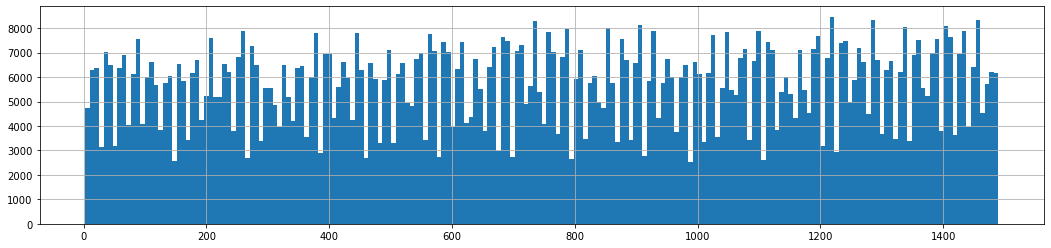

In [1169]:
# Время объявлений в ходе всего периода сбора данных
history.hour.hist(bins=200, figsize=(18, 4))

<AxesSubplot:>

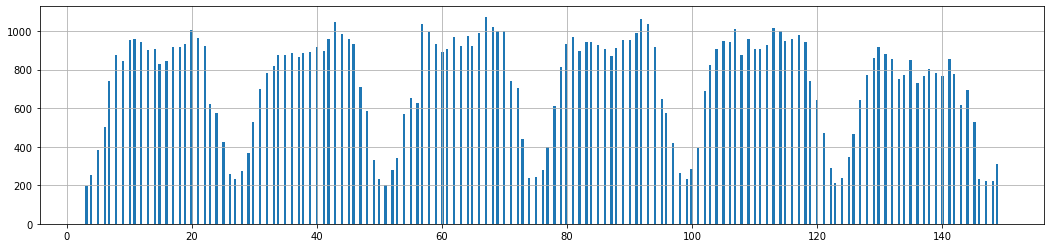

In [1170]:
# Подробнее
history[history.hour < 150].hour.hist(bins=400, figsize=(18, 4))

<AxesSubplot:>

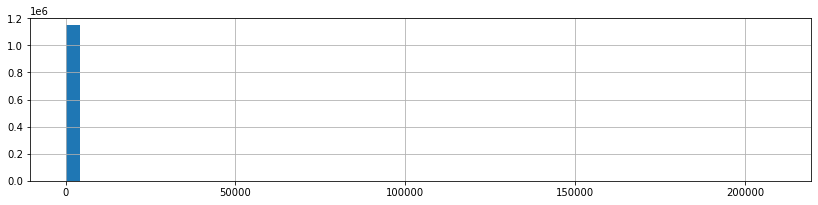

In [1171]:
# Цены объявлений
history.cpm.hist(bins=50)

<AxesSubplot:>

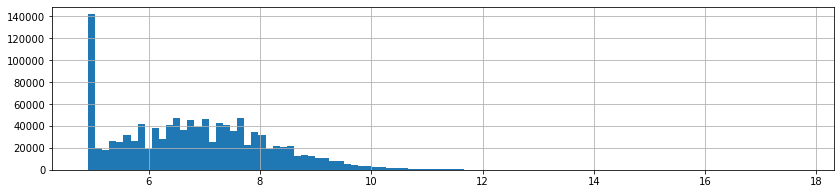

In [1172]:
# Логарифмированные
cpms = history.cpm.apply(np.log2)
cpms.hist(bins=100)

<AxesSubplot:>

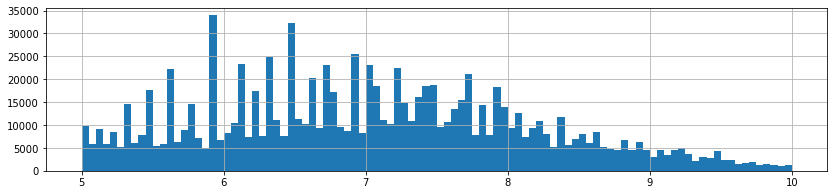

In [1173]:
# Подробнее 
cpms[(cpms > 5) & (cpms < 10)].hist(bins=100)

21


Text(0, 0.5, 'Количество таких платформ')

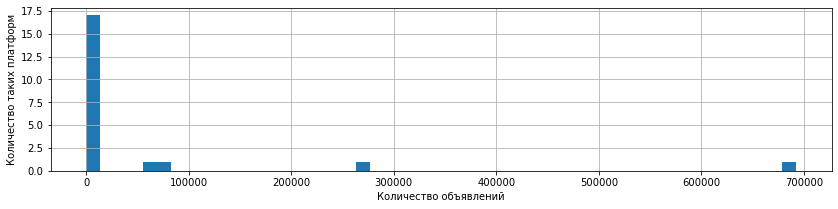

In [1174]:
# Что за платформы для рекламы? Сколько их?

print(len(history.publisher.unique()))
vc = history.publisher.value_counts()
vc.hist(bins=50)
plt.xlabel('Количество объявлений')
plt.ylabel('Количество таких платформ')

Text(0, 0.5, 'Количество платформ')

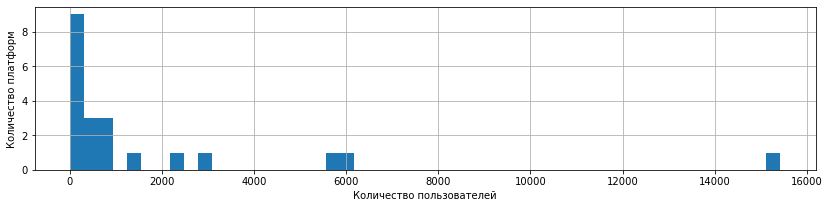

In [1175]:
# Сколько уникальных пользователей на платформах?

history.groupby('publisher').user_id.apply(lambda users: len(set(users))).hist(bins=50)
plt.xlabel('Количество пользователей')
plt.ylabel('Количество платформ')

In [1176]:
# Какой трафик на каждой платформе?

# Посчитаем для каждого часа: сколько постов было на каждой платформе?

n_publishers = len(history.publisher.unique())
posts_per_hour_by_publishers = []
TAKE_FIRST_N_HOURS = 24 * 4

for hour, hour_data in history[history.hour < TAKE_FIRST_N_HOURS].groupby('hour'):
    publishers_posts = hour_data.value_counts('publisher')

    counts = [0 for _ in range(n_publishers)]
    for pub_id, posts_n in list(publishers_posts.items()):
        counts[pub_id - 1] = posts_n

    posts_per_hour_by_publishers.append([hour] + counts)

df = pd.DataFrame.from_records(posts_per_hour_by_publishers, columns=['hour'] + list(history.publisher.unique()))
df.head()

,hour,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,21,20
0,3,100,67,11,1,3,1,7,0,2,...,0,0,0,0,2,1,0,0,0,0
1,4,173,51,10,0,1,1,11,1,2,...,1,0,0,0,1,0,0,0,0,0
2,5,246,91,21,1,1,4,12,3,2,...,2,1,0,0,0,0,0,0,0,0
3,6,346,95,27,2,0,5,16,1,4,...,0,0,0,0,1,1,0,0,0,0
4,7,488,157,29,2,5,5,42,3,6,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Количество постов')

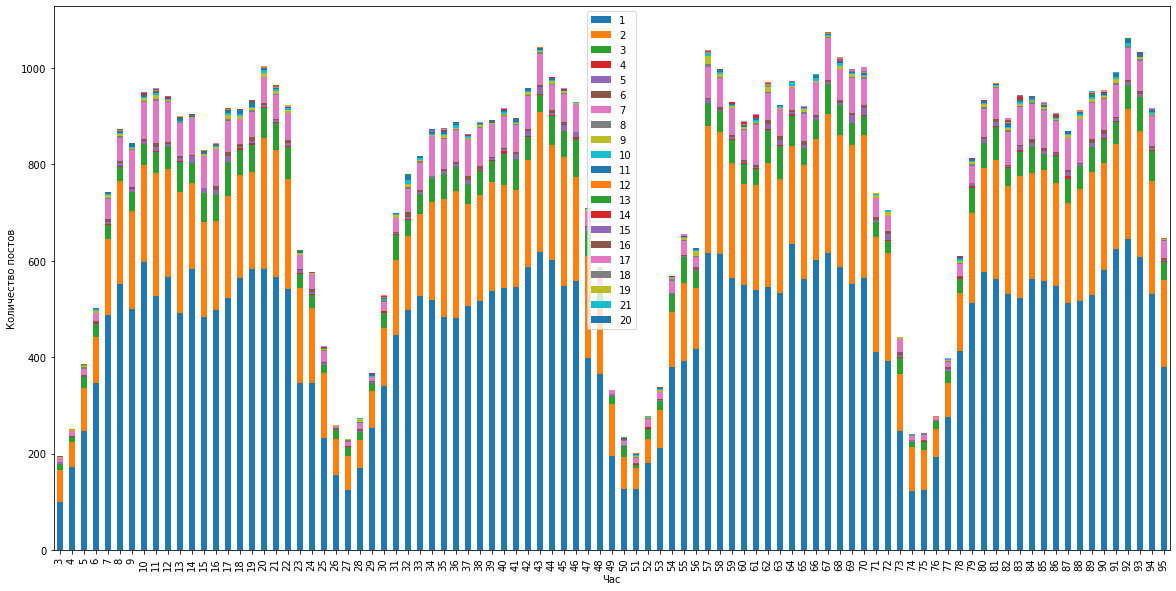

In [1177]:
df.plot.bar(x='hour', stacked=True, figsize=(20, 10))
plt.xlabel('Час')
plt.ylabel('Количество постов')

<AxesSubplot:>

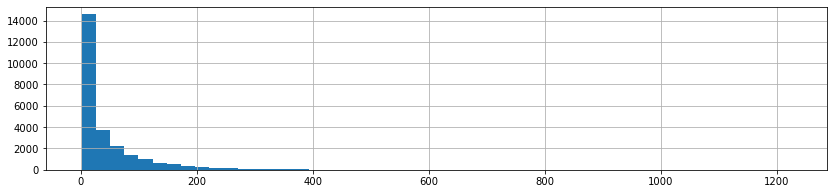

In [1178]:
# И сколько постов посмотрел каждый пользователь?
vc = history.value_counts('user_id')
vc.hist(bins=50)

Text(0, 0.5, 'Количество таких пользователей')

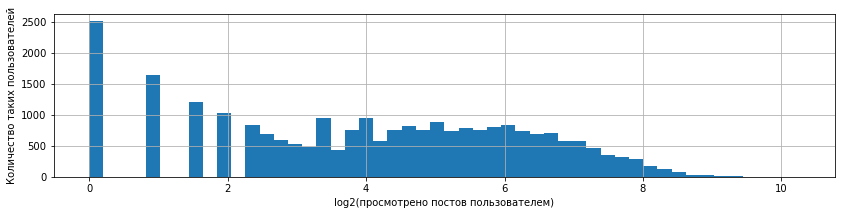

In [1179]:
# Логарифмируем
np.log2(vc).hist(bins=50)
plt.xlabel('log2(просмотрено постов пользователем)')
plt.ylabel('Количество таких пользователей')

#### О результате рекламных компаний

In [1180]:
posts = pd.read_csv('data/ads.csv')
posts.head(7)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",3
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4
5,141.0,1288,1322,"3,8,11,15",856,"111,217,235,247,292,340,398,540,541,546,581,61...",5
6,250.0,1198,1451,"1,3,7,10,13,18",336,"24,43,96,124,150,256,299,313,430,450,552,557,5...",6


<AxesSubplot:>

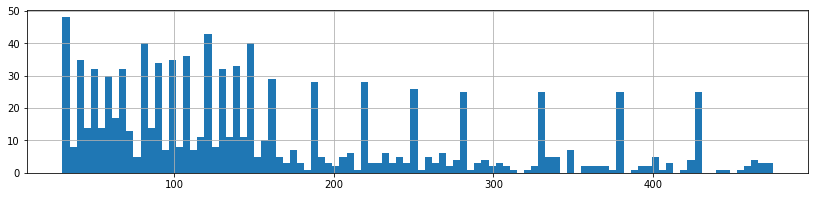

In [1181]:
# Сколько по итогам аукциона стоит объявление
posts.cpm.hist(bins=100)

<AxesSubplot:>

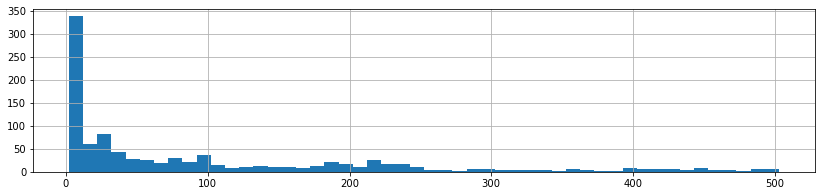

In [1182]:
# Сколько часов длится рекламная компания

duration = (posts.hour_end - posts.hour_start)
duration.hist(bins=50)

Text(0, 0.5, 'количество объявлений')

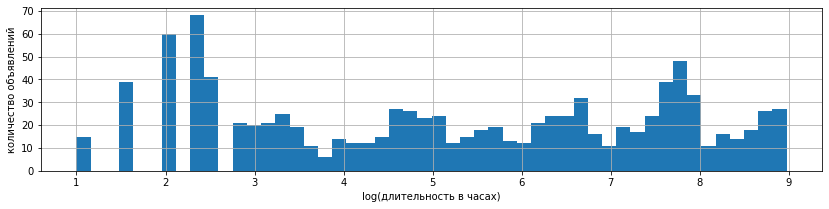

In [1183]:
np.log2(duration).hist(bins=50)
plt.xlabel('log(длительность в часах)')
plt.ylabel('количество объявлений')

<AxesSubplot:>

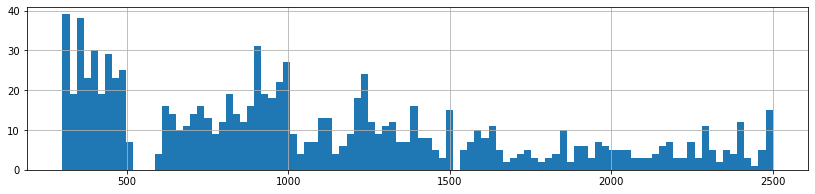

In [1184]:
# На какую аудиторию крутилось объявление

posts.audience_size.hist(bins=100)

#### Об охвате

In [1185]:
answers = pd.read_csv('data/target.csv')
answers.head(7)

,ad_id,at_least_one
0,0,0.0430
1,1,0.0130
2,2,0.0878
3,3,0.2295
4,4,0.3963
5,5,0.0187
6,6,0.3839


<AxesSubplot:>

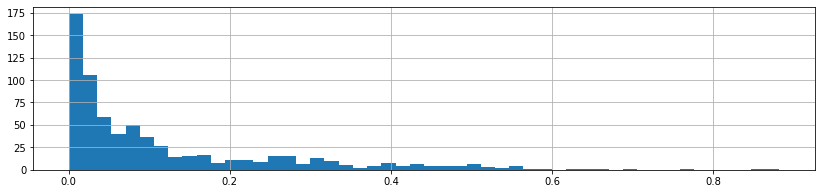

In [1186]:
# Какая часть аудитории увидело объявление хоть раз
answers.at_least_one.hist(bins=50)

Если у вас нет непонимания и вопросов о данных, то вы посмотрели хороший анализ данных. Возможно выше неплохой анализ

### Построим модель

#### Выделим числовые признаки

In [1187]:
import seaborn as sns

In [1188]:
# Соберём простую информацию по каждому объявлению в датасет

# Добавим номер объявления
#posts = posts.assign(id=posts.index)
#answers = answers.assign(id=answers.index)

ads = pd.merge(posts, answers, on='ad_id')
ads.head(3)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id,at_least_one
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0,0.0430
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1,0.0130
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2,0.0878


In [1189]:
# функция возвращает статистическую информацию по списку пользователей
def users_info(row):
    sam_users = users.iloc[row['users_list']]
    n_city = sam_users.city_id.nunique()
    age_median = sam_users.age.median()
    age_mean = sam_users.age.mean()
    sigma = sam_users.age.std()
    age_m2g = age_median - 2 * sigma
    if age_m2g < 0:
        age_m2g = 0
    age_p2g = age_median + 2 * sigma
    return {
        'ad_id': row.ad_id,
        'age_min': int(age_m2g),
        'age_median': int(age_median),
        'age_mean': int(age_mean),
        'age_max': int(age_p2g),
        'n_city': n_city
    }

In [1190]:
ads['users_list'] = ads.user_ids.apply(lambda s: list(map(int, s.split(','))))

data = ads.apply(users_info, axis=1)
ads_ = pd.DataFrame(columns=['ad_id',
                             'age_min', 'age_median', 'age_mean', 'age_max',
                             'n_city'
                             ],
                    data=data.to_list())
ads = pd.merge(ads, ads_, on='ad_id')
ads.drop(['users_list'], axis=1, inplace=True)

In [1191]:
start = ads.hour_start.to_numpy()
end = ads.hour_end.to_numpy()


def peek(start, end):
    s_hour = start % 24
    e_hour = end % 24
    days = ((end - e_hour) - (start - s_hour) - 1) // 24
    in_first = max(0, 22 - max(s_hour, 8))
    in_last = max(0, min(e_hour, 22) - 8)
    return days * 14 + in_first + in_last


def hours_in_peek(start, end):
    res = np.array([])
    for i in range(len(start)):
        res = np.append(res, peek(start[i], end[i]))
    return res


ads = ads.assign(peek_hours=pd.Series(hours_in_peek(start, end)))

Добавили наши фичи в таблицу

In [1192]:
ads

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id,at_least_one,age_min,age_median,age_mean,age_max,n_city,peek_hours
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0,0.0430,0,27,28,59,7,56.0
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1,0.0130,0,26,28,60,372,0.0
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2,0.0878,0,28,29,62,280,14.0
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",3,0.2295,0,26,27,58,7,43.0
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4,0.3963,38,44,44,49,416,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,40.0,969,1420,"1,3,4,5,15",2320,"4,8,10,15,20,35,38,69,74,88,95,96,99,106,110,1...",695,0.4272,0,22,25,59,607,265.0
696,291.0,1302,1320,"1,2,4,7",1260,"25,42,86,95,98,100,122,130,131,160,213,215,223...",696,0.1849,12,14,14,15,315,14.0
697,130.0,1120,1320,"1,2,3,6,20",2357,"8,12,18,85,111,118,120,128,142,145,148,153,164...",697,0.3963,25,27,27,28,557,118.0
698,110.0,802,805,"1,3,9,11,16",364,"8,90,286,346,416,452,522,553,627,906,984,1025,...",698,0.0192,0,27,29,62,1,3.0


Добавляем в полезные колонки наши созданные фичи и переносим at least one в начало

In [1193]:
# Добавим пару простых признаков
# n_p - количество площадок на которых опубликована реклама
# duration - длительность рекламы
ads = ads.assign(
    n_publishers=ads.publishers.apply(lambda s: len(s.split(','))),
    duration=ads.hour_end - ads.hour_start,
)

useful_columns = [
    'at_least_one',
    'cpm', 'duration', 'n_publishers', 'audience_size',
    'age_min', 'age_median', 'age_mean', 'age_max',
    'n_city', 'peek_hours'
]

ads = ads[useful_columns]
ads.head(5)

,at_least_one,cpm,duration,n_publishers,audience_size,age_min,age_median,age_mean,age_max,n_city,peek_hours
0,0.0430,220.0,95,2,1906,0,27,28,59,7,56.0
1,0.0130,312.0,6,2,1380,0,26,28,60,372,0.0
2,0.0878,70.0,20,6,888,0,28,29,62,280,14.0
3,0.2295,240.0,82,2,440,0,26,27,58,7,43.0
4,0.3963,262.0,238,4,1476,38,44,44,49,416,140.0


Таблица корреляций

In [1194]:
def heatmap(data: pd.DataFrame):
    plt.figure(figsize=(13, 12))
    sns.heatmap(data.corr(), square=True, linecolor='white', annot=True)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()

<Figure size 864x720 with 0 Axes>

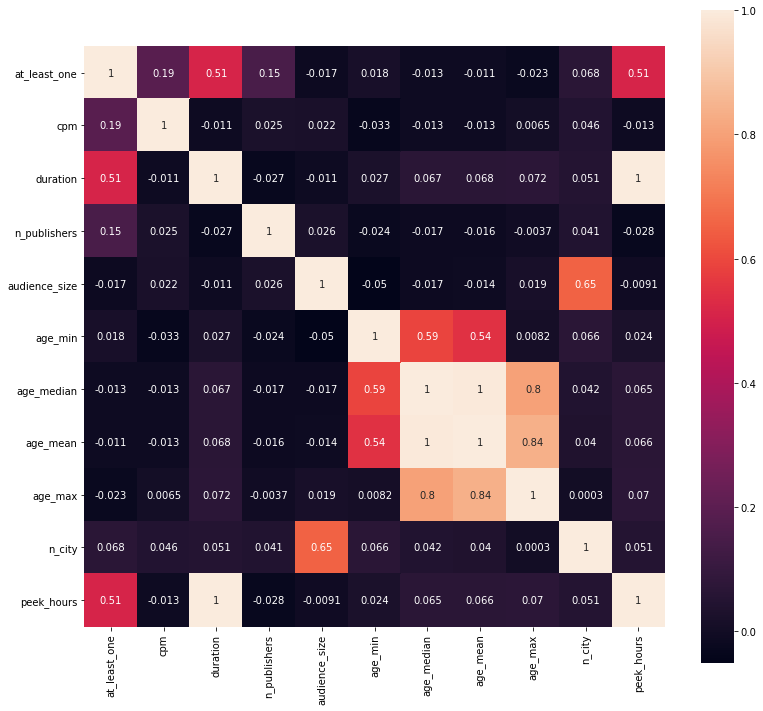

In [1195]:
plt.figure(figsize=(12, 10))
heatmap(ads)

Добавим своих доп фичей

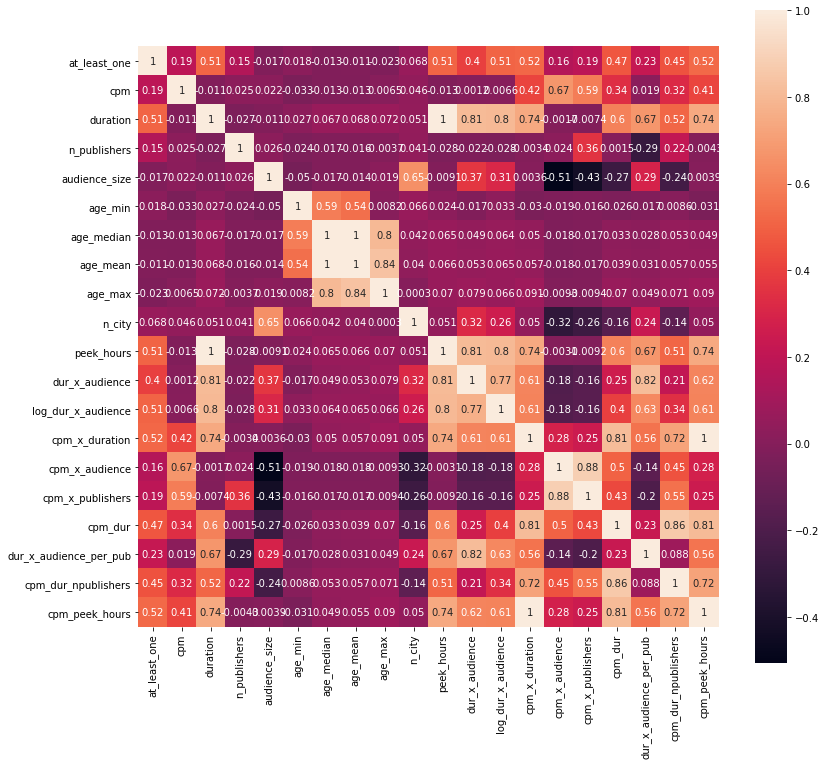

In [1196]:
# Добавим дата саенс
ads_featured = ads.assign(
    dur_x_audience=ads.duration * ads.audience_size,
    log_dur_x_audience=np.log(ads.duration * ads.audience_size),
    cpm_x_duration=ads.cpm * ads.duration,

    cpm_x_audience=ads.cpm / ads.audience_size,
    cpm_x_publishers=(ads.cpm / ads.audience_size) * ads.n_publishers,
    cpm_dur=ads.duration * ads.cpm / ads.audience_size,
    dur_x_audience_per_pub=ads.duration * ads.audience_size / ads.n_publishers,
    cpm_dur_npublishers=ads.duration * ads.cpm / ads.audience_size * ads.n_publishers,
    cpm_peek_hours=ads.cpm * ads.peek_hours
)
heatmap(ads_featured)

#### Обучим линейную регрессию

In [1197]:
from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [1198]:
def make_xy(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    x = data.drop('at_least_one', axis=1)
    y = data['at_least_one']
    return x, y

In [1199]:
def mape(pred: np.ndarray, trueth: np.ndarray) -> np.ndarray:
    # mean_absolute_percentage_error with clipping huge values
    err = np.array(abs(pred - trueth) / trueth)
    err[err > 20] = 20  # clip 2000% error
    return err

Посчитаем ошибки и в процентах и абсолютные значения

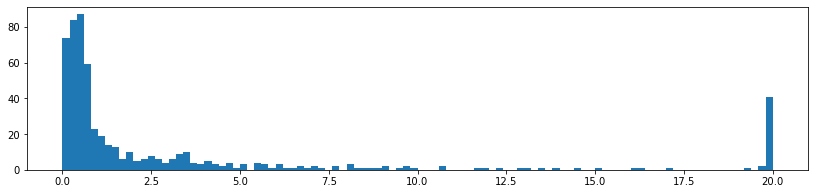

Ошибка на train: MAPE = 3.2266071904623224  MAE = -4.696144267108642e-18
Ошибка на test: MAPE = 3.160590983598901  MAE = -0.006792681928527904


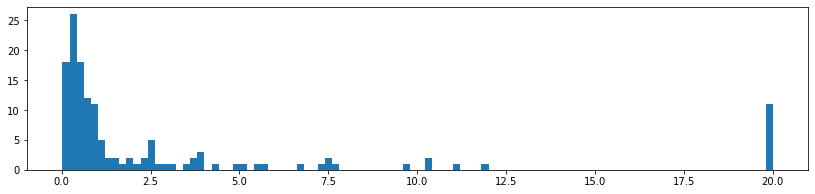

In [1200]:
train, test = train_test_split(ads,
                               test_size=0.2,
                               random_state=42)

# Обучим модель
x_train, y_train = make_xy(train)
model = LinearRegression().fit(x_train, y_train)

# Оценим ошибку
y_pred = model.predict(x_train)
errors = mape(y_pred, y_train)
plt.hist(errors, bins=100)
plt.show()
print('Ошибка на train: MAPE =', (errors).mean(), ' MAE =', (y_pred - y_train).mean())

# Оценим ошибку на тесте
x_test, y_test = make_xy(test)
y_pred = model.predict(x_test)
errors = mape(y_pred, y_test)
plt.hist(errors, bins=100)
print('Ошибка на test: MAPE =', (errors).mean(), ' MAE =', (y_pred - y_test).mean())

### Насколько вообще разделимы данные?

In [1201]:
import umap

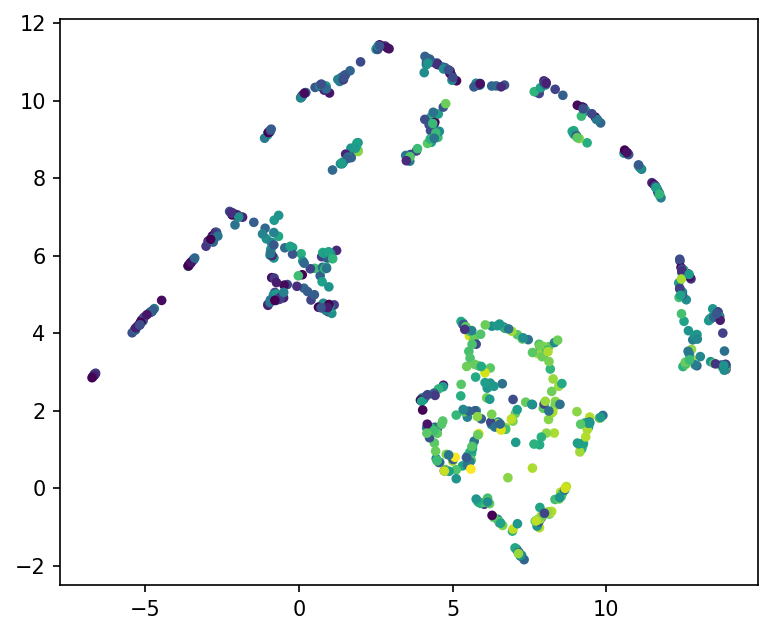

In [1202]:
# Покажем похожие объявления точками, а охват цветом
embedding = umap.UMAP().fit_transform(ads[['cpm', 'duration', 'n_publishers']])

plt.figure(figsize=(6, 5), dpi=150)

color = np.log1p(ads.at_least_one * 100)
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color)

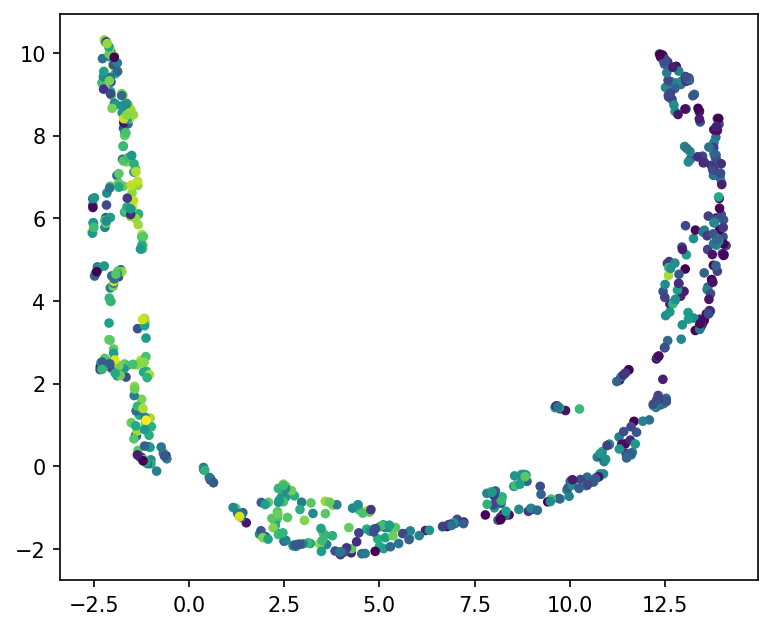

In [1203]:
# Покажем похожие объявления точками, а охват цветом. Но на данных с доп фичами
embedding = umap.UMAP().fit_transform(ads_featured[['cpm', 'duration', 'n_publishers',
                                                    'age_min', 'age_median', 'age_mean', 'age_max',
                                                    'n_city', 'peek_hours',
                                                    'dur_x_audience', 'log_dur_x_audience', 'cpm_x_duration',
                                                    'cpm_x_audience', 'cpm_x_publishers',
                                                    'cpm_dur', 'dur_x_audience_per_pub', 'cpm_dur_npublishers',
                                                    'cpm_peek_hours']])

plt.figure(figsize=(6, 5), dpi=150)

color = np.log1p(ads.at_least_one * 100)
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color)

 обучим линейную регресию с расширенным набором фичей

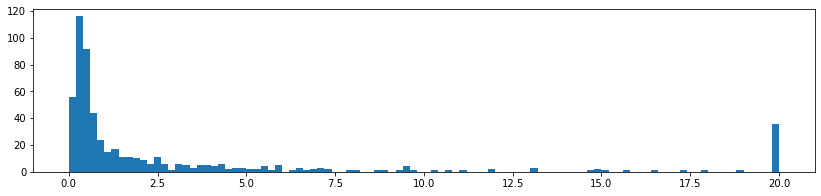

Ошибка на train: MAPE = 3.0130405485107254  MAE = 1.0244781213840172e-16
Ошибка на test: MAPE = 3.094027271035249  MAE = -0.007731041097540596


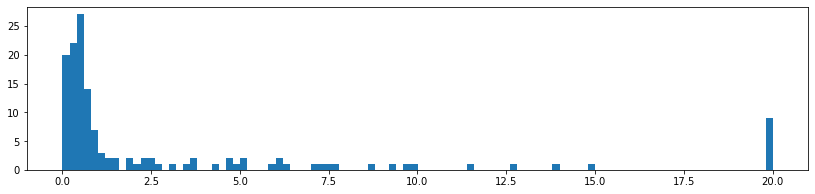

In [1204]:
train, test = train_test_split(
    ads.assign(
        dur_x_audience=ads.duration * ads.audience_size,
        log_dur_x_audience=np.log(ads.duration * ads.audience_size),
        cpm_x_duration=ads.cpm * ads.duration,
        cpm_x_audience=ads.cpm / ads.audience_size,
        cpm_x_publishers=(ads.cpm / ads.audience_size) * ads.n_publishers,
        cpm_dur=ads.duration * ads.cpm / ads.audience_size,
        dur_x_audience_per_pub=ads.duration * ads.audience_size / ads.n_publishers,
        cpm_dur_npublishers=ads.duration * ads.cpm / ads.audience_size * ads.n_publishers,
        cpm_peek_hours=ads.cpm * ads.peek_hours
    ),
    test_size=0.2,
    random_state=42
)

# Обучим модель
x_train, y_train = make_xy(train)
model = LinearRegression().fit(x_train, y_train)

# Оценим ошибку
y_pred = model.predict(x_train)
errors = mape(y_pred, y_train)
plt.hist(errors, bins=100)
plt.show()
print('Ошибка на train: MAPE =', (errors).mean(), ' MAE =', (y_pred - y_train).mean())

# Оценим ошибку на тесте
x_test, y_test = make_xy(test)
y_pred = model.predict(x_test)
errors = mape(y_pred, y_test)
plt.hist(errors, bins=100)
print('Ошибка на test: MAPE =', (errors).mean(), ' MAE =', (y_pred - y_test).mean())

In [1205]:
from catboost import CatBoostRegressor

Learning rate set to 0.035203
0:	learn: 0.1426629	total: 938us	remaining: 937ms
1:	learn: 0.1408942	total: 1.74ms	remaining: 867ms
2:	learn: 0.1390329	total: 2.63ms	remaining: 876ms
3:	learn: 0.1372413	total: 3.47ms	remaining: 864ms
4:	learn: 0.1356979	total: 4.3ms	remaining: 857ms
5:	learn: 0.1343199	total: 5.13ms	remaining: 850ms
6:	learn: 0.1327836	total: 5.98ms	remaining: 848ms
7:	learn: 0.1313597	total: 6.84ms	remaining: 848ms
8:	learn: 0.1297970	total: 7.67ms	remaining: 844ms
9:	learn: 0.1284085	total: 8.51ms	remaining: 842ms
10:	learn: 0.1271335	total: 9.39ms	remaining: 844ms
11:	learn: 0.1257807	total: 10.3ms	remaining: 846ms
12:	learn: 0.1246085	total: 11.3ms	remaining: 855ms
13:	learn: 0.1234005	total: 12ms	remaining: 848ms
14:	learn: 0.1223421	total: 12.9ms	remaining: 847ms
15:	learn: 0.1212506	total: 14ms	remaining: 859ms
16:	learn: 0.1202809	total: 14.9ms	remaining: 862ms
17:	learn: 0.1193312	total: 16.1ms	remaining: 878ms
18:	learn: 0.1184299	total: 16.9ms	remaining: 873m

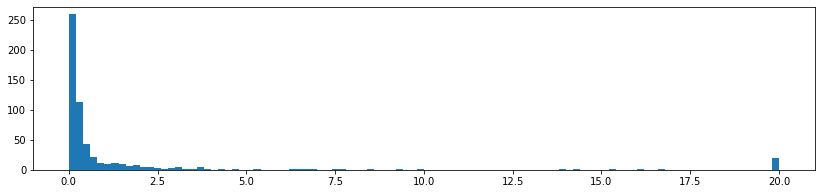

Ошибка на train: MAPE = 1.4362267420997281  MAE = -3.5517938194232784e-05
Ошибка на test: MAPE = 3.0824885869683807  MAE = -0.013135621738092462


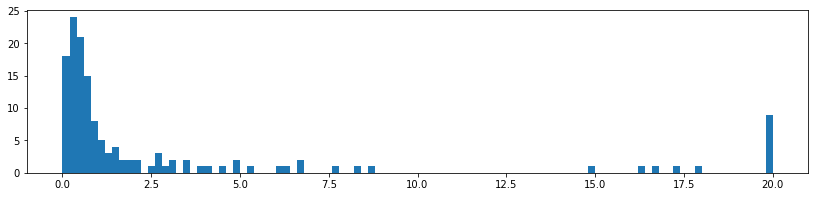

In [1206]:
train, test = train_test_split(
    ads.assign(
        dur_x_audience=ads.duration * ads.audience_size,
        log_dur_x_audience=np.log(ads.duration * ads.audience_size),
        cpm_x_duration=ads.cpm * ads.duration,
        cpm_x_audience=ads.cpm / ads.audience_size,
        cpm_x_publishers=(ads.cpm / ads.audience_size) * ads.n_publishers,
        cpm_dur=ads.duration * ads.cpm / ads.audience_size,
        dur_x_audience_per_pub=ads.duration * ads.audience_size / ads.n_publishers,
        cpm_dur_npublishers=ads.duration * ads.cpm / ads.audience_size * ads.n_publishers,
        cpm_peek_hours=ads.cpm * ads.peek_hours
    ),
    test_size=0.2,
    random_state=42
)

# Обучим модель
x_train, y_train = make_xy(train)
model = CatBoostRegressor(random_state=42).fit(x_train, y_train)  # запустим алгоритм с параметрами по-умолчанию

y_pred = model.predict(x_train)
# Оценим ошибку
errors = mape(y_pred, y_train)
plt.hist(errors, bins=100)
plt.show()
print('Ошибка на train: MAPE =', (errors).mean(), ' MAE =', (y_pred - y_train).mean())

# Оценим ошибку на тесте
x_test, y_test = make_xy(test)
y_pred = model.predict(x_test)
errors = mape(y_pred, y_test)
plt.hist(errors, bins=100)
print('Ошибка на test: MAPE =', (errors).mean(), ' MAE =', (y_pred - y_test).mean())

In [1207]:
# загрузим данные
answers_sol = pd.read_csv('data/sample_solution.csv')
answers_sol.head(7)

,ad_id,at_least_one
0,700,0.118536
1,701,0.118536
2,702,0.118536
3,703,0.118536
4,704,0.118536
5,705,0.118536
6,706,0.118536


In [1208]:
# Соберём простую информацию по каждому объявлению в датасет
ads = pd.merge(posts, answers_sol, on='ad_id')
ads.head(3)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id,at_least_one
0,330.0,1184,1189,"2,3,5,11",344,"30,62,82,103,128,339,400,418,463,494,618,706,7...",700,0.118536
1,79.0,1275,1426,"7,14,18",1960,"3,8,11,26,27,59,77,83,90,124,128,132,170,171,1...",701,0.118536
2,130.0,1452,1457,"1,9,15",2400,"3,15,21,75,76,85,91,103,110,122,126,127,128,14...",702,0.118536


In [1209]:
ads['users_list'] = ads.user_ids.apply(lambda s: list(map(int, s.split(','))))

In [1210]:
data = ads.apply(users_info, axis=1)
ads_ = pd.DataFrame(columns=['ad_id', 'n_city', 'peek_hours',
                             'age_min', 'age_median', 'age_mean', 'age_max'
                             ],
                    data=data.to_list())
ads = pd.merge(ads, ads_, on='ad_id')
ads.drop(['users_list'], axis=1, inplace=True)

In [1211]:
ads

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id,at_least_one,n_city,peek_hours,age_min,age_median,age_mean,age_max
0,330.0,1184,1189,"2,3,5,11",344,"30,62,82,103,128,339,400,418,463,494,618,706,7...",700,0.118536,141,NaN,0,26,28,64
1,79.0,1275,1426,"7,14,18",1960,"3,8,11,26,27,59,77,83,90,124,128,132,170,171,1...",701,0.118536,1,NaN,0,28,29,63
2,130.0,1452,1457,"1,9,15",2400,"3,15,21,75,76,85,91,103,110,122,126,127,128,14...",702,0.118536,547,NaN,0,27,28,62
3,134.0,1466,1469,"2,7,8,12,17",1960,"17,34,42,43,49,52,63,67,87,105,114,120,151,152...",703,0.118536,479,NaN,0,27,29,64
4,50.0,1271,1301,"1,2,15,18",1428,"13,27,44,139,150,155,169,171,194,212,214,224,2...",704,0.118536,294,NaN,0,31,31,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,127.0,1095,1154,"2,7,12,15,16",368,"38,50,143,237,456,649,653,698,881,893,1100,127...",1003,0.118536,148,NaN,0,27,28,60
304,90.0,1052,1056,"2,21",484,"1,4,61,212,230,348,356,372,429,431,462,540,593...",1004,0.118536,174,NaN,0,26,28,60
305,122.0,1058,1063,"2,5",704,"1,23,29,104,136,176,201,206,250,269,355,403,44...",1005,0.118536,227,NaN,0,25,28,62
306,138.0,932,1169,"1,2,7",1210,"67,73,80,146,182,202,212,254,307,377,383,385,3...",1006,0.118536,347,NaN,41,88,88,134


In [1212]:
# Добавим пару простых признаков

ads = ads.assign(
    n_publishers=ads.publishers.apply(lambda s: len(s.split(','))),
    duration=ads.hour_end - ads.hour_start
)

useful_columns = [
    'at_least_one',
    'cpm', 'duration', 'n_publishers', 'audience_size',
    'age_min', 'age_median', 'age_mean', 'age_max',
    'n_city', 'peek_hours'
]

ads = ads[useful_columns]
ads.head(5)

,at_least_one,cpm,duration,n_publishers,audience_size,age_min,age_median,age_mean,age_max,n_city,peek_hours
0,0.118536,330.0,5,4,344,0,26,28,64,141,NaN
1,0.118536,79.0,151,3,1960,0,28,29,63,1,NaN
2,0.118536,130.0,5,3,2400,0,27,28,62,547,NaN
3,0.118536,134.0,3,5,1960,0,27,29,64,479,NaN
4,0.118536,50.0,30,4,1428,0,31,31,64,294,NaN


In [1213]:
# Добавим дата саенс
ads_featured = ads.assign(
    dur_x_audience=ads.duration * ads.audience_size,
    log_dur_x_audience=np.log(ads.duration * ads.audience_size),
    cpm_x_duration=ads.cpm * ads.duration,
    cpm_x_audience=ads.cpm / ads.audience_size,
    cpm_x_publishers=(ads.cpm / ads.audience_size) * ads.n_publishers,
    cpm_dur=ads.duration * ads.cpm / ads.audience_size,
    dur_x_audience_per_pub=ads.duration * ads.audience_size / ads.n_publishers,
    cpm_dur_npublishers=ads.duration * ads.cpm / ads.audience_size * ads.n_publishers,
    cpm_peek_hours=ads.cpm * ads.peek_hours
)

In [1214]:
x_sol, y_sol = make_xy(ads_featured)
y_pred = model.predict(x_sol)

In [1215]:
answers_sol['at_least_one'] = y_pred

<AxesSubplot:>

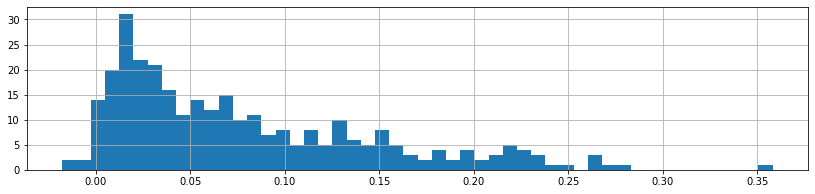

In [1216]:
answers_sol.at_least_one.hist(bins=50)

In [1217]:
answers_sol.to_csv('solution_1.csv', index=False)